## Regression using the subclassing API
* ### Model saving and restoring
* ### Using Callbacks

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.config.list_physical_devices('GPU')

## Boston Housing regression dataset

In [4]:
boston_housing=tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = boston_housing

In [6]:
X_train_full.shape

(404, 13)

In [7]:
X_train, y_train = X_train_full[:-50], y_train_full[:-50]
X_valid, y_valid = X_train_full[-50:], y_train_full[-50:]

X_new=X_test[:3]
y_new=y_test[:3]

In [8]:
tf.random.set_seed(42)

# Model definition with subclass API 

In [9]:
class WideAndDeepModel(K.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.norm_layer_wide=K.layers.Normalization()
        self.norm_layer_deep=K.layers.Normalization()
        self.hidden_layer1=K.layers.Dense(units, activation=activation)
        self.hidden_layer2=K.layers.Dense(units, activation=activation)
        self.main_output=K.layers.Dense(1, name='main_output')
        self.aux_output=K.layers.Dense(1, name='aux_output')
        
    def call(self, inputs):
        input_wide=inputs[0]
        input_deep=inputs[1]
        norm_wide=self.norm_layer_wide(input_wide)
        norm_deep=self.norm_layer_deep(input_deep)
        hidden1=self.hidden_layer1(norm_deep)
        hidden2=self.hidden_layer2(hidden1)
        concat=K.layers.concatenate([norm_wide, hidden2])
        
        return {'main_output':self.main_output(concat), 'aux_output':self.aux_output(hidden2)}
        

## Model instance

In [ ]:
model=WideAndDeepModel(30, activation='relu', name='my_cool_model')

In [11]:
model.layers

# Model training

In [12]:
optimizer=K.optimizers.Adam(lr=1e-3)

In [13]:
loss_dict={'main_output':'mse',
            'aux_output':'mse'}

loss_weights_dict={'main_output':0.9,
                   'aux_output':0.1}

In [14]:
model.compile(loss=loss_dict,
              loss_weights=loss_weights_dict,
              optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

## Multiple inputs and targets data split and passing as dicts for named model inputs

In [15]:
X_train_wide, X_train_deep=X_train[:, :5], X_train[:, 5:]
X_valid_wide, X_valid_deep=X_valid[:, :5], X_valid[:, 5:]
X_test_wide, X_test_deep=X_test[:, :5], X_test[:, 5:]

X_new_wide, X_new_deep=X_test_wide[:3], X_test_deep[:3]
y_new=y_test[:3]

#input_dict={'input_wide':X_train_wide, 'input_deep':X_train_deep}
#input_valid_dict={'input_wide':X_valid_wide, 'input_deep':X_valid_deep}

target_dict={'main_output':y_train, 'aux_output':y_train}
target_valid_dict={'main_output':y_valid, 'aux_output':y_valid}

#input_test_dict={'input_wide':X_test_wide, 'input_deep':X_test_deep}
target_test_dict={'main_output':y_test, 'aux_output':y_test}

#X_new_dict={'input_wide':X_new_wide, 'input_deep':X_new_deep}

## Normalization() layers adaptation

In [16]:
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)

## Training

In [17]:
history = model.fit((X_train_wide, X_train_deep),
                    target_dict,
                    epochs=3,
                    validation_data=((X_valid_wide, X_valid_deep), target_valid_dict))

Epoch 1/3
 1/12 [=>............................] - ETA: 14s - loss: 499.6737 - aux_output_loss: 541.9780 - main_output_loss: 494.9732 - aux_output_root_mean_squared_error: 23.2804 - main_output_root_mean_squared_error: 22.2480

2023-06-12 18:53:16.699643: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12/12 [==============================] - 2s 18ms/step - loss: 562.7211 - aux_output_loss: 609.8820 - main_output_loss: 557.4811 - aux_output_root_mean_squared_error: 24.6958 - main_output_root_mean_squared_error: 23.6110 - val_loss: 521.6600 - val_aux_output_loss: 581.9895 - val_main_output_loss: 514.9567 - val_aux_output_root_mean_squared_error: 24.1245 - val_main_output_root_mean_squared_error: 22.6927
Epoch 2/3
12/12 [==============================] - 0s 4ms/step - loss: 541.5157 - aux_output_loss: 610.8641 - main_output_loss: 533.8104 - aux_output_root_mean_squared_error: 24.7157 - main_output_root_mean_squared_error: 23.1043 - val_loss: 499.6144 - val_aux_output_loss: 582.4955 - val_main_output_loss: 490.4054 - val_aux_output_root_mean_squared_error: 24.1349 - val_main_output_root_mean_squared_error: 22.1451
Epoch 3/3
12/12 [==============================] - 0s 4ms/step - loss: 516.4127 - aux_output_loss: 611.3945 - main_output_loss: 505.8593 - aux_output_root_mean_squared_error: 

## Model evaluation

In [18]:
history.params

{'verbose': 1, 'epochs': 3, 'steps': 12}

<Axes: >

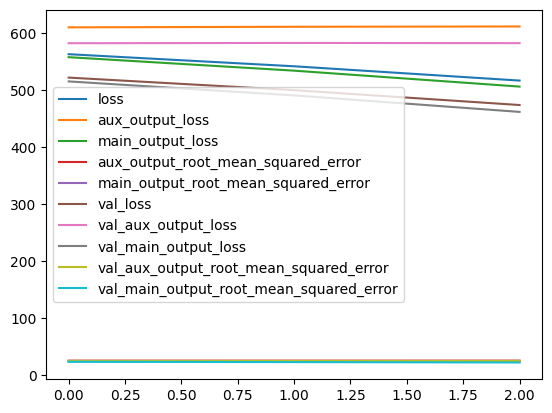

In [19]:
pd.DataFrame(history.history).plot()

In [20]:
# Nice fotmatting example

#pd.DataFrame(history.history).plot(figsize=(8, 5),
#                                  xlim=[0, history.params['epochs']],
#                                  #ylim=[0, 1],
#                                  grid=True,
#                                  xlabel='Epoch',
#                                  style=["r--", "r--.", "b-", "b-*"])
#plt.show()

In [21]:
eval_results=model.evaluate((X_test_wide, X_test_deep),
                           target_test_dict,
                           return_dict=True)

4/4 [==============================] - 0s 2ms/step - loss: 521.8596 - aux_output_loss: 635.6313 - main_output_loss: 509.2183 - aux_output_root_mean_squared_error: 25.2117 - main_output_root_mean_squared_error: 22.5659


In [22]:
eval_results.keys()

dict_keys(['loss', 'aux_output_loss', 'main_output_loss', 'aux_output_root_mean_squared_error', 'main_output_root_mean_squared_error'])

In [23]:
eval_results

{'loss': 521.859619140625,
 'aux_output_loss': 635.63134765625,
 'main_output_loss': 509.21832275390625,
 'aux_output_root_mean_squared_error': 25.21173095703125,
 'main_output_root_mean_squared_error': 22.565866470336914}

In [24]:
y_pred_tuple=model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 81ms/step


In [25]:
y_pred_tuple

{'main_output': array([[5.2322674],
        [1.5901372],
        [2.1565557]], dtype=float32),
 'aux_output': array([[-1.0290345 ],
        [-0.28648648],
        [-0.2742954 ]], dtype=float32)}

In [26]:
y_new

array([ 7.2, 18.8, 19. ])

In [27]:
# Model loss outputs
model.loss

{'main_output': 'mse', 'aux_output': 'mse'}

## Saving and restoring the model

In [28]:
model.save('WideAndDeepModel', save_format='tf')

INFO:tensorflow:Assets written to: WideAndDeepModel/assets


In [29]:
model=K.models.load_model('WideAndDeepModel')

In [30]:
model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 56ms/step


{'aux_output': array([[ 0.77326554],
        [ 0.23248304],
        [-0.1603841 ]], dtype=float32),
 'main_output': array([[0.83145565],
        [1.1357802 ],
        [2.3012276 ]], dtype=float32)}

## Loading using low level TF method

In [ ]:
model2=tf.saved_model.load('WideAndDeepModel')

In [ ]:
[v.name for v in model2.trainable_variables]

In [ ]:
with tf.GradientTape() as tape:
    pred=model2( tf.constant(X_train[:1], dtype=tf.float32, name='input'))['output']
    loss = (10-pred)**2
    

In [ ]:
[v.name for v in tape.watched_variables()]

## Loaded model can be fine tuned 
API details:

https://www.tensorflow.org/guide/saved_model



optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

## TF Callbacks

In [28]:
class PrintValTrainRatioCallback(K.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        loss_ratio=logs['val_loss']/(logs['loss'])
        acc_ratio=logs['val_main_output_root_mean_squared_error']/(logs['main_output_root_mean_squared_error'])
        print(f'\n Epoch={epoch}, ACC_RATIO={acc_ratio:.2f}, LOSS RATIO={loss_ratio:.2f} \n')
      

In [29]:
checkpoint_cb=K.callbacks.ModelCheckpoint('my_checkpoints',
                                         save_weights_only=True)

early_stopping_cb=K.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)

of_cb=PrintValTrainRatioCallback()

In [30]:
history=model.fit((X_train_wide, X_train_deep),
                    target_dict,
                    epochs=3,
                    validation_data=((X_valid_wide, X_valid_deep), target_valid_dict),
                    callbacks=[checkpoint_cb, early_stopping_cb, of_cb])



Epoch 1/3
 1/12 [=>............................] - ETA: 0s - loss: 440.2383 - aux_output_loss: 542.1879 - main_output_loss: 428.9106 - aux_output_root_mean_squared_error: 23.2849 - main_output_root_mean_squared_error: 20.7102
 Epoch=0, ACC_RATIO=0.95, LOSS RATIO=0.91 

12/12 [==============================] - 0s 19ms/step - loss: 486.0919 - aux_output_loss: 610.1104 - main_output_loss: 472.3121 - aux_output_root_mean_squared_error: 24.7004 - main_output_root_mean_squared_error: 21.7327 - val_loss: 440.2412 - val_aux_output_loss: 579.0338 - val_main_output_loss: 424.8199 - val_aux_output_root_mean_squared_error: 24.0631 - val_main_output_root_mean_squared_error: 20.6112
Epoch 2/3
 1/12 [=>............................] - ETA: 0s - loss: 496.8179 - aux_output_loss: 649.4570 - main_output_loss: 479.8580 - aux_output_root_mean_squared_error: 25.4844 - main_output_root_mean_squared_error: 21.9057
 Epoch=1, ACC_RATIO=0.94, LOSS RATIO=0.89 

12/12 [==============================] - 0s 6ms/step

# Tensorboard callback

In [31]:
from pathlib import Path
from time import strftime

In [32]:
strftime('run_%Y_%m_%d_%H_%M_%S')

'run_2023_06_12_18_53_31'

In [33]:
def get_run_logdir(root_logdir='my_logs'):
    return Path(root_logdir) / strftime('run_%Y_%m_%d_%H_%M_%S')

In [34]:
run_logdir=get_run_logdir()

In [35]:
run_logdir

PosixPath('my_logs/run_2023_06_12_18_53_32')

In [ ]:
tensorboard_cb=K.callbacks.TensorBoard(run_logdir,
                                      profile_batch=(100, 200))

In [38]:
history=model.fit((X_train_wide, X_train_deep),
                    target_dict,
                    epochs=3,
                    validation_data=((X_valid_wide, X_valid_deep), target_valid_dict),
                     callbacks=[tensorboard_cb])

Epoch 1/3
12/12 [==============================] - 0s 6ms/step - loss: 11.5623 - aux_output_loss: 13.0831 - main_output_loss: 11.3933 - aux_output_root_mean_squared_error: 3.6171 - main_output_root_mean_squared_error: 3.3754 - val_loss: 9.9337 - val_aux_output_loss: 12.3934 - val_main_output_loss: 9.6604 - val_aux_output_root_mean_squared_error: 3.5204 - val_main_output_root_mean_squared_error: 3.1081
Epoch 2/3
12/12 [==============================] - 0s 5ms/step - loss: 11.5081 - aux_output_loss: 13.0588 - main_output_loss: 11.3358 - aux_output_root_mean_squared_error: 3.6137 - main_output_root_mean_squared_error: 3.3669 - val_loss: 9.8015 - val_aux_output_loss: 12.3518 - val_main_output_loss: 9.5182 - val_aux_output_root_mean_squared_error: 3.5145 - val_main_output_root_mean_squared_error: 3.0852
Epoch 3/3
12/12 [==============================] - 0s 5ms/step - loss: 11.6798 - aux_output_loss: 13.2720 - main_output_loss: 11.5029 - aux_output_root_mean_squared_error: 3.6431 - main_outp

In [39]:
%load_ext tensorboard

In [40]:
%tensorboard --logdir=./my_logs